# Monthly Cross-Section: Analysis

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot
import mypack.clas as clas

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

In [80]:
tqdm.tqdm.pandas()

## Data

In [7]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly.pkl')
df_xs_predictions = pd.read_pickle('df_xs_predictions_monthly.pkl')

In [ ]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly_NEW.pkl')
df_xs_predictions = pd.read_pickle('df_xs_predictions_monthly_NEW.pkl')

In [17]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly_TEMP.pkl')
df_xs_predictions = pd.read_pickle('df_xs_predictions_monthly_TEMP.pkl')

In [8]:
hmm_name = 'HMM_full'

In [8]:
hmm_name = 'HMM_expand'

In [68]:
hmm_name = 'HMM_roll_40'

## Create Data to Analyse

In [9]:
df_xs_analysis = df_xs_estimates[hmm_name]
df_xs_analysis.columns = pd.MultiIndex.from_product([[0],df_xs_analysis.columns], names=['horizon','variable'])

df_xs_analysis = df_xs_analysis\
    .merge(df_xs_predictions[hmm_name], left_index=True, right_index=True)

## Index Comparisons

In [10]:
df_index_comparison = pd.DataFrame(df_xs_analysis[[(1,'cumstd'),(3,'cumstd'),(12,'cumstd')]])\
    .groupby('Date').mean()*np.sqrt([12,4,1])*100

VIX = web.DataReader('VIXCLS', 'fred', start = '1926-01-01')
VIX.index = VIX.index+pd.tseries.offsets.MonthEnd(0)
VIX = VIX.groupby('DATE').tail(1)
VIX.columns = pd.MultiIndex.from_tuples([(1,'VIX')])

JLN = data.download_jln_financial_uncertainty()
JLN.index = JLN.index+pd.tseries.offsets.MonthEnd(0)
JLN.columns = pd.MultiIndex.from_product([[1,3,12],['JLN financial']], names=['a','horizon'])

df_index_comparison = df_index_comparison\
    .merge(df_xs_analysis[[(1,'cumentropy'),(3,'cumentropy'),(12,'cumentropy')]].groupby('Date').mean(), left_index=True, right_index=True)\
    .merge(df_xs_analysis[[('ss','entropy')]].groupby('Date').mean(), left_index=True, right_index=True, how='left')\
    .merge(VIX, left_index=True, right_index=True, how='left')\
    .merge(JLN, left_index=True, right_index=True, how='left')

### Correlation Matrix

In [11]:
index_correlations_table = pd.DataFrame(np.tril(df_index_comparison.corr(method='pearson')), index=df_index_comparison.columns.swaplevel(0,1), columns=df_index_comparison.columns.swaplevel(0,1))

index_correlations_table = index_correlations_table.replace(0,"")

#calc.export_df_to_latex(index_correlations_table, 'indexCorrelationsTable'+hmm_name)

index_correlations_table

variable              cumstd               cumentropy               entropy  \
horizon                    1      3     12          1      3     12      ss   
variable      horizon                                                         
cumstd        1       1.0000                                                  
              3       0.9968 1.0000                                           
              12      0.8938 0.9264 1.0000                                    
cumentropy    1       0.7554 0.7340 0.5621     1.0000                         
              3       0.7971 0.7799 0.6226     0.9941 1.0000                  
              12      0.8441 0.8376 0.7231     0.9305 0.9645 1.0000           
entropy       ss      0.1351 0.1910 0.4296     0.0490 0.1271 0.3248  1.0000   
VIX           1       0.7927 0.7895 0.7731     0.5268 0.5741 0.6380  0.1579   
JLN financial 1       0.7591 0.7559 0.7415     0.5324 0.5645 0.5881  0.1144   
              3       0.7559 0.7528 0.7387     0.5408 0.5700 0.5865  0.0991   
              12      0.7450 0.7421 0.7294     0.5549 0.5763 0.5742  0.0449   

variable                 VIX JLN financial                
horizon                    1             1      3     12  
variable      horizon                                     
cumstd        1                                           
              3                                           
              12                                          
cumentropy    1                                           
              3                                           
              12                                          
entropy       ss                                          
VIX           1       1.0000                              
JLN financial 1       0.7980        1.0000                
              3       0.7954        0.9992 1.0000         
              12      0.7870        0.9875 0.9929 1.0000

### Lead-Lag relations

In [12]:
df_leadlag_y = df_index_comparison.iloc[:,[0,3,4,5]]
df_leadlag_x = df_index_comparison.iloc[:,7:]

In [13]:
rowlabels = ['$\mathbb{V}_t[r_{t+1}]$ vs. VIX',
             '$\mathbb{H}_t[M_{t+1}]$ vs. JLN financial h=1',
             '$\mathbb{H}_t[M_{(t+1,\dots,t+3)}]$ vs. JLN financial h=3',
             '$\mathbb{H}_t[M_{(t+1,\dots,t+12)}]$ vs. JLN financial h=12']
leadlag_table = pd.DataFrame(index=rowlabels, columns=pd.MultiIndex.from_product([['Benchmark lagged by $l$ periods'],list(range(-3,4))]))

In [14]:
for comparison in range(0,len(df_leadlag_y.columns)):
    for pair in range(0,7):
        leadlag_table.iat[comparison,pair] = df_leadlag_y.iloc[:,comparison].to_frame().join(df_leadlag_x.iloc[:,comparison].shift(pair-3)).corr(method='pearson').iloc[0,1]

#calc.export_df_to_latex(leadlag_table, 'leadlagTable'+hmm_name)
leadlag_table

Benchmark lagged by $l$ periods  \
                                                                                -3   
$\mathbb{V}_t[r_{t+1}]$ vs. VIX                                             0.5284   
$\mathbb{H}_t[M_{t+1}]$ vs. JLN financial h=1                               0.3812   
$\mathbb{H}_t[M_{(t+1,\dots,t+3)}]$ vs. JLN fin...                          0.4045   
$\mathbb{H}_t[M_{(t+1,\dots,t+12)}]$ vs. JLN fi...                          0.4027   

                                                                         \
                                                       -2     -1      0   
$\mathbb{V}_t[r_{t+1}]$ vs. VIX                    0.5853 0.6850 0.7927   
$\mathbb{H}_t[M_{t+1}]$ vs. JLN financial h=1      0.4276 0.4804 0.5324   
$\mathbb{H}_t[M_{(t+1,\dots,t+3)}]$ vs. JLN fin... 0.4505 0.5103 0.5700   
$\mathbb{H}_t[M_{(t+1,\dots,t+12)}]$ vs. JLN fi... 0.4447 0.5095 0.5742   

                                                                         
                                                        1      2      3  
$\mathbb{V}_t[r_{t+1}]$ vs. VIX                    0.8170 0.7973 0.7686  
$\mathbb{H}_t[M_{t+1}]$ vs. JLN financial h=1      0.6038 0.6564 0.6847  
$\mathbb{H}_t[M_{(t+1,\dots,t+3)}]$ vs. JLN fin... 0.6371 0.6849 0.7084  
$\mathbb{H}_t[M_{(t+1,\dots,t+12)}]$ vs. JLN fi... 0.6290 0.6675 0.6843

### Benchmark Plots

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


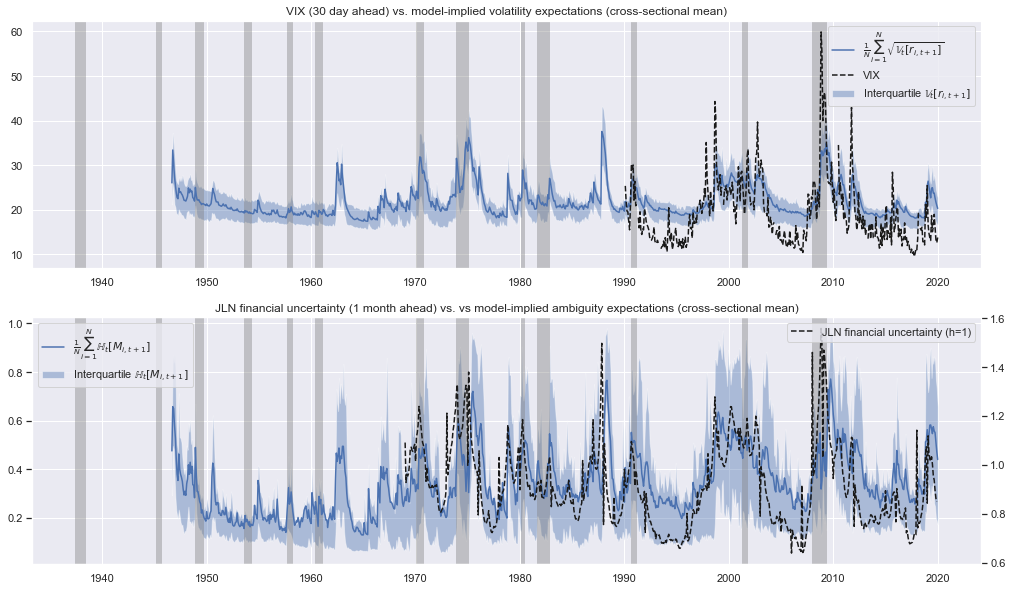

In [15]:
fig,axes = plt.subplots(2,1,figsize=[17,10])

ax = axes[0]
ax.plot(df_index_comparison[(1,'cumstd')], label='$\\frac{1}{N}\sum_{i=1}^{N}\sqrt{\mathbb{V}_t[r_{i,t+1}]}$')
ax.fill_between(x=df_xs_analysis[[(1,'cumstd')]].groupby('Date').mean().index,\
                y1=df_xs_analysis[[(1,'cumstd')]].groupby('Date').quantile(0.25).values.squeeze()*np.sqrt(12)*100,\
                y2=df_xs_analysis[[(1,'cumstd')]].groupby('Date').quantile(0.75).values.squeeze()*np.sqrt(12)*100,\
                label='Interquartile $\mathbb{V}_t[r_{i,t+1}]$',
                alpha = 0.4)

ax.plot(df_index_comparison[(1,'VIX')], label='VIX', linestyle='--', c='k')
plot.add_recession_bars(ax, startdate=df_index_comparison.index[120])
ax.legend()
ax.set_title('VIX (30 day ahead) vs. model-implied volatility expectations (cross-sectional mean)')

ax = axes[1]
ax2 = ax.twinx()
ax2.grid(False)
ax.plot(df_index_comparison[(1,'cumentropy')], label='$\\frac{1}{N}\sum_{i=1}^{N}\mathbb{H}_t[M_{i,t+1}]$')
ax.fill_between(x=df_xs_analysis[[(1,'cumentropy')]].groupby('Date').mean().index,\
                y1=df_xs_analysis[[(1,'cumentropy')]].groupby('Date').quantile(0.25).values.squeeze(),\
                y2=df_xs_analysis[[(1,'cumentropy')]].groupby('Date').quantile(0.75).values.squeeze(),\
                label='Interquartile $\mathbb{H}_t[M_{i,t+1}]$',
                alpha=0.4)
ax2.plot(df_index_comparison[(1,'JLN financial')], label='JLN financial uncertainty (h=1)', linestyle='--', c='k')

ax.set_title('JLN financial uncertainty (1 month ahead) vs. vs model-implied ambiguity expectations (cross-sectional mean)')
plot.add_recession_bars(ax, startdate=df_index_comparison.index[120])
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

#fig.savefig('indexComparisonPlots'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [16]:
# # BULLSHIT regression
# y=newframe['h=1'].diff(1).loc[newframe['h=1'].diff(1).notna()]
# x=sm.add_constant(newframe[(1, 'entropy')].diff(1).loc[newframe['h=1'].diff(1).notna()])
# sm.OLS(y,x).fit().summary()

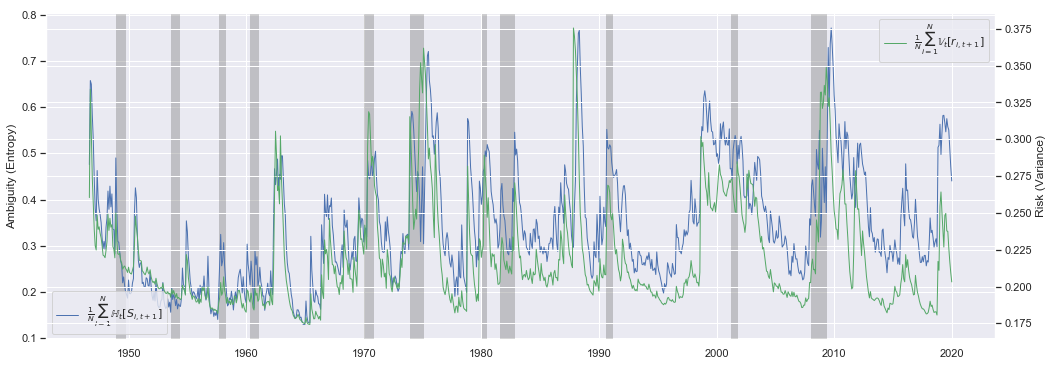

In [17]:
h=1

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax1 = plt.subplots(figsize=[17,6])
ax2 = ax1.twinx()

ax1.plot(df_xs_predictions[hmm_name,h,'cumentropy'].groupby('Date').mean(), linewidth=1, color=cycle[0], alpha=1, label='$\\frac{1}{N}\sum_{i=1}^{N}\mathbb{H}_t[S_{i,t+1}]$', rasterized=True)
ax1.set_ylabel('Ambiguity (Entropy)')

ax2.plot(df_xs_predictions[hmm_name,h,'cumstd'].groupby('Date').mean()*np.sqrt(12/h), linewidth=1, color=cycle[2], alpha=1, label='$\\frac{1}{N}\sum_{i=1}^{N}\mathbb{V}_t[r_{i,t+1}]$', rasterized=True)
ax2.set_ylabel('Risk (Variance)')

ax1.legend(loc='lower left')
ax2.legend()

plot.add_recession_bars(ax1, startdate=df_xs_predictions.index[df_xs_predictions[hmm_name,h,'entropy'].notna()][0][0])

plt.show()

#fig.savefig('XSIndicesPlot'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

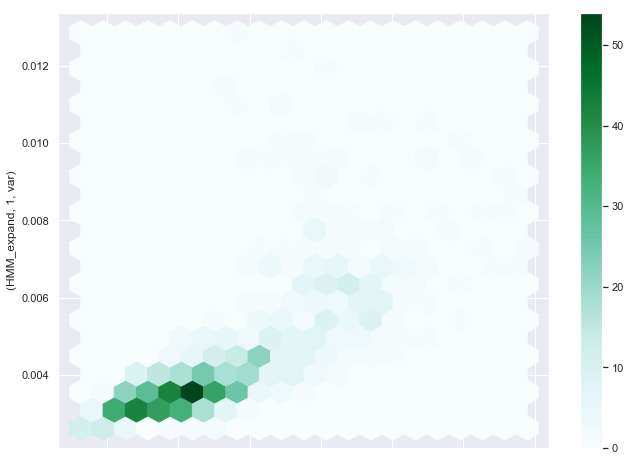

In [18]:
df_xs_predictions[[(hmm_name,h,'entropy'),(hmm_name,h,'var')]].groupby('Date').mean().plot.hexbin(x=(hmm_name,h,'entropy'), y=(hmm_name,h,'var'), gridsize=20, figsize=[11,8])
plt.show()

## Calculate

### Data Preparation

In [45]:
df_xs_reg[('mu_t',0)].describe()

count   40313.0000
mean        3.5588
std         2.8318
min         0.0023
25%         1.6703
50%         2.6913
75%         4.7823
max        27.9581
Name: (mu_t, 0), dtype: float64

In [47]:
df_xs_reg = pd.DataFrame([], columns=pd.MultiIndex.from_product([[],[]]))

# Standard errors
df_xs_reg[('mu_se',0)] = (df_xs_analysis[(0,'filt_prob_0')]*df_xs_analysis[(0,'mu_0_se')]+\
                          df_xs_analysis[(0,'filt_prob_1')]*df_xs_analysis[(0,'mu_1_se')])
df_xs_reg[('sigma2_se',0)] = (df_xs_analysis[(0,'filt_prob_0')]*df_xs_analysis[(0,'sigma2_0_se')]+\
                              df_xs_analysis[(0,'filt_prob_1')]*df_xs_analysis[(0,'sigma2_1_se')])
# ranks
df_xs_reg[('rank_mu_se',0)] = df_xs_reg[('mu_se',0)].unstack().rank(axis=1, ascending=True).stack()
df_xs_reg[('rank_sigma2_se',0)] = df_xs_reg[('sigma2_se',0)].unstack().rank(axis=1, ascending=True).stack()

# t-stats
# df_xs_reg[('mu_t_w',0)] = (df_xs_analysis[(0,'filt_prob_0')]*abs(df_xs_analysis[(0,'mu_0')]/df_xs_analysis[(0,'mu_0_se')])+\
#                          df_xs_analysis[(0,'filt_prob_1')]*abs(df_xs_analysis[(0,'mu_1')]/df_xs_analysis[(0,'mu_1_se')]))
# df_xs_reg[('sigma2_t_w',0)] = (df_xs_analysis[(0,'filt_prob_0')]*abs(df_xs_analysis[(0,'sigma2_0')]/df_xs_analysis[(0,'sigma2_0_se')])+\
#                              df_xs_analysis[(0,'filt_prob_1')]*abs(df_xs_analysis[(0,'sigma2_1')]/df_xs_analysis[(0,'sigma2_1_se')]))
df_xs_reg[('mu_t',0)] = abs(((df_xs_analysis[(0,'mu_0')]-df_xs_analysis[(0,'mu_1')])\
                        /(df_xs_analysis[(0,'mu_0_se')]**2+df_xs_analysis[(0,'mu_1_se')]**2-2*df_xs_analysis[(0,'mu_cov')])**0.5))
df_xs_reg[('sigma2_t',0)] = abs(((df_xs_analysis[(0,'sigma2_0')]-df_xs_analysis[(0,'sigma2_1')])\
                        /(df_xs_analysis[(0,'sigma2_0_se')]**2+df_xs_analysis[(0,'sigma2_1_se')]**2-2*df_xs_analysis[(0,'sigma_cov')])**0.5))

# ranks
df_xs_reg[('rank_mu_t',0)] = df_xs_reg[('mu_t',0)].unstack().rank(axis=1, ascending=True).stack()
df_xs_reg[('rank_sigma2_t',0)] = df_xs_reg[('sigma2_t',0)].unstack().rank(axis=1, ascending=True).stack()

# Kolmogorov-Smirnov statistics
ks = []
for rowindex in tqdm.trange(0,len(df_xs_analysis)):
    m0, m1, s0, s1 = df_xs_analysis[[(0,'mu_0'),(0,'mu_1'),(0,'sigma2_0'),(0,'sigma2_1')]].iloc[rowindex]
    ks += [calc.calculate_kolmogorov_smirnov_distance(m0,m1,s0,s1)]
df_xs_reg[('KS',0)] = ks
# ranks
df_xs_reg[('rank_KS',0)] = df_xs_reg[('KS',0)].unstack().rank(axis=1, ascending=True).stack()

# steady state
df_xs_reg[('Ess','ss')] = df_xs_analysis[('ss','mean')]
df_xs_reg[('Vss','ss')] = df_xs_analysis[('ss','var')]
df_xs_reg[('Sss','ss')] = df_xs_analysis[('ss','skew')]
df_xs_reg[('Kss','ss')] = df_xs_analysis[('ss','kurt')]
df_xs_reg[('SDss','ss')] = df_xs_analysis[('ss','std')]
df_xs_reg[('Hss','ss')] = df_xs_analysis[('ss','entropy')]
# ranks
df_xs_reg[('rank_Hss','ss')] = df_xs_reg[('Hss','ss')].unstack().rank(axis=1, ascending=True).stack()

# interactions
df_xs_reg[('Hss_*_KS','ss')] = (df_xs_reg[('Hss','ss')]*df_xs_reg[('KS',0)])
df_xs_reg[('sq_Hss_*_KS','ss')] = (df_xs_reg[('Hss','ss')]*df_xs_reg[('KS',0)])**0.5
df_xs_reg[('Hss_+_KS','ss')] = (df_xs_reg[('Hss','ss')]+df_xs_reg[('KS',0)])
df_xs_reg[('rank_Hss_+_rank_KS','ss')] = (df_xs_reg[('rank_Hss','ss')]+df_xs_reg[('rank_KS',0)])

df_xs_reg[('Hss_*_KS_*_mu_t','ss')] = (df_xs_reg[('Hss','ss')]*df_xs_reg[('KS',0)]*df_xs_reg[('mu_t',0)])
df_xs_reg[('Hss_*_KS_*_sigma2_t','ss')] = (df_xs_reg[('Hss','ss')]*df_xs_reg[('KS',0)]*df_xs_reg[('sigma2_t',0)])
df_xs_reg[('sq_Hss_*_KS_*_mu_t','ss')] = (df_xs_reg[('Hss','ss')]*df_xs_reg[('KS',0)]*df_xs_reg[('mu_t',0)])**(1/3)
df_xs_reg[('sq_Hss_*_KS_*_sigma2_t','ss')] = (df_xs_reg[('Hss','ss')]*df_xs_reg[('KS',0)]*df_xs_reg[('sigma2_t',0)])**(1/3)
df_xs_reg[('Hss_+_KS_+_mu_t','ss')] = (df_xs_reg[('Hss','ss')]+df_xs_reg[('KS',0)]+df_xs_reg[('mu_t',0)])
df_xs_reg[('Hss_+_KS_+_sigma2_t','ss')] = (df_xs_reg[('Hss','ss')]+df_xs_reg[('KS',0)]+df_xs_reg[('sigma2_t',0)])
df_xs_reg[('rank_Hss_+_rank_KS_+_rank_mu_t','ss')] = (df_xs_reg[('rank_Hss','ss')]+df_xs_reg[('rank_KS',0)]+df_xs_reg[('rank_mu_t',0)])
df_xs_reg[('rank_Hss_+_rank_KS_+_rank_sigma2_t','ss')] = (df_xs_reg[('rank_Hss','ss')]+df_xs_reg[('rank_KS',0)]+df_xs_reg[('rank_sigma2_t',0)])

# Expectations
for h in tqdm.trange(1,13):
    df_xs_reg[('return',h)] = ((1+df_xs_estimates[('data','return')].unstack()).rolling(window=h).apply(np.prod, raw=True) - 1).stack()
    df_xs_reg[('E',h)] = df_xs_analysis[(h,'cummean')]
    df_xs_reg[('SD',h)] = df_xs_analysis[(h,'cumstd')]
    df_xs_reg[('V',h)] = df_xs_analysis[(h,'cumvar')]
    df_xs_reg[('S',h)] = df_xs_analysis[(h,'cumskew')]
    df_xs_reg[('K',h)] = df_xs_analysis[(h,'cumkurt')]
    df_xs_reg[('H',h)] = df_xs_analysis[(h,'cumentropy')]
    #ranks
    df_xs_reg[('rank_V',h)] = df_xs_reg[('V',h)].unstack().rank(axis=1, ascending=True).stack()
    df_xs_reg[('rank_H',h)] = df_xs_reg[('H',h)].unstack().rank(axis=1, ascending=True).stack()
    # logs
    #df_xs_reg[('log_V',h)] = np.log(df_xs_reg[('V',h)])
    #df_xs_reg[('log_H',h)] = np.log(df_xs_reg[('H',h)])
    
    # interactions
    df_xs_reg[('H_*_KS',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('KS',0)])
    df_xs_reg[('H_*_KS',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('KS',0)])
    df_xs_reg[('sq_H_*_KS',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('KS',0)])**0.5
    df_xs_reg[('H_+_KS',h)] = (df_xs_reg[('H',h)]+df_xs_reg[('KS',0)])
    df_xs_reg[('rank_H_+_rank_KS',h)] = (df_xs_reg[('rank_H',h)]+df_xs_reg[('rank_KS',0)])
    
    df_xs_reg[('H_*_KS_*_mu_t',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('KS',0)]*df_xs_reg[('mu_t',0)])
    df_xs_reg[('H_*_KS_*_sigma2_t',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('KS',0)]*df_xs_reg[('sigma2_t',0)])
    df_xs_reg[('sq_H_*_KS_*_mu_t',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('KS',0)]*df_xs_reg[('mu_t',0)])**(1/3)
    df_xs_reg[('sq_H_*_KS_*_sigma2_t',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('KS',0)]*df_xs_reg[('sigma2_t',0)])**(1/3)
    df_xs_reg[('H_+_KS_+_mu_t',h)] = (df_xs_reg[('H',h)]+df_xs_reg[('KS',0)]+df_xs_reg[('mu_t',0)])
    df_xs_reg[('H_+_KS_+_sigma2_t',h)] = (df_xs_reg[('H',h)]+df_xs_reg[('KS',0)]+df_xs_reg[('sigma2_t',0)])
    df_xs_reg[('rank_H_+_rank_KS_+_rank_mu_t',h)] = (df_xs_reg[('rank_H',h)]+df_xs_reg[('rank_KS',0)]+df_xs_reg[('rank_mu_t',0)])
    df_xs_reg[('rank_H_+_rank_KS_+_rank_sigma2_t',h)] = (df_xs_reg[('rank_H',h)]+df_xs_reg[('rank_KS',0)]+df_xs_reg[('rank_sigma2_t',0)])
    
    df_xs_reg[('H_*_Hss',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('Hss','ss')])
    df_xs_reg[('H_*_Hss',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('Hss','ss')])
    df_xs_reg[('sq_H_*_Hss',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('Hss','ss')])**0.5
    df_xs_reg[('H_+_Hss',h)] = (df_xs_reg[('H',h)]+df_xs_reg[('Hss','ss')])
    df_xs_reg[('rank_H_+_rank_Hss',h)] = (df_xs_reg[('rank_H',h)]+df_xs_reg[('rank_Hss','ss')])
    
    df_xs_reg[('H_*_Hss_*_mu_t',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('Hss','ss')]*df_xs_reg[('mu_t',0)])
    df_xs_reg[('H_*_Hss_*_sigma2_t',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('Hss','ss')]*df_xs_reg[('sigma2_t',0)])
    df_xs_reg[('sq_H_*_Hss_*_mu_t',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('Hss','ss')]*df_xs_reg[('mu_t',0)])**(1/3)
    df_xs_reg[('sq_H_*_Hss_*_sigma2_t',h)] = (df_xs_reg[('H',h)]*df_xs_reg[('Hss','ss')]*df_xs_reg[('sigma2_t',0)])**(1/3)
    df_xs_reg[('H_+_Hss_+_mu_t',h)] = (df_xs_reg[('H',h)]+df_xs_reg[('Hss','ss')]+df_xs_reg[('mu_t',0)])
    df_xs_reg[('H_+_Hss_+_sigma2_t',h)] = (df_xs_reg[('H',h)]+df_xs_reg[('Hss','ss')]+df_xs_reg[('sigma2_t',0)])
    df_xs_reg[('rank_H_+_rank_Hss_+_rank_mu_t',h)] = (df_xs_reg[('rank_H',h)]+df_xs_reg[('rank_Hss','ss')]+df_xs_reg[('rank_mu_t',0)])
    df_xs_reg[('rank_H_+_rank_Hss_+_rank_sigma2_t',h)] = (df_xs_reg[('rank_H',h)]+df_xs_reg[('rank_Hss','ss')]+df_xs_reg[('rank_sigma2_t',0)])

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.23s/it]


### Variable Summary Stats

In [99]:
order = [29,30,31,32,33,34,35,15,4,5,8]

variable_names = ['$r_{i,t}$',
                  '$\mathbb{E}_t[r_{i,t+1}]$',
                  '$\mathbb{SD}_t[r_{i,t+1}]$',
                  '$\mathbb{V}_t[r_{i,t+1}]$',
                  '$\mathbb{S}_t[r_{i,t+1}]$',
                  '$\mathbb{K}_t[r_{i,t+1}]$',
                  '$\mathbb{H}_t[M_{i,t+1}]$',
                  '$H_t[M_{i,ss}]$',
                  '$t_{[\mu_{i,t,0}=\mu_{i,t,1}]}$',
                  '$t_{[\sigma_{i,t,0}=\sigma_{i,t,1}]}$',
                  '$KS(\phi_{0,t},\phi_{1,t})$',
                  ]

x = df_xs_reg.iloc[:,order].loc[df_xs_reg[('mu_se',0)].notna()]

regressors_table = pd.DataFrame(index=['N total','N (industry)','mean','std','min','median','max','skewness','kurtosis','Jarque-Bera (p)','autocorr (1)','Durbin-Watson','Aug. Dickey-Fuller (p)','']+variable_names, columns=variable_names)

regressors_table.loc['N total',:] = x.count().values
regressors_table.loc['N (industry)',:] = x.unstack().count().unstack().mean(axis=1).values
regressors_table.loc['mean',:] = x.unstack().mean().unstack().mean(axis=1).values
regressors_table.loc['std',:] = x.unstack().std().unstack().mean(axis=1).values
regressors_table.loc['min',:] = x.unstack().min().unstack().mean(axis=1).values
regressors_table.loc['median',:] = x.unstack().median().unstack().mean(axis=1).values
regressors_table.loc['max',:] = x.unstack().max().unstack().mean(axis=1).values
regressors_table.loc['skewness',:] = x.unstack().skew().unstack().mean(axis=1).values
regressors_table.loc['kurtosis',:] = x.unstack().kurt().unstack().mean(axis=1).values

#regressors_table.loc['autocorrelation (1-12)',:] = x.apply(lambda col: sum([col.autocorr(l) for l in range(1,2)]), axis=0).values

regressors_table.loc['Jarque-Bera (p)',:] = x.unstack().apply(lambda col: sm.stats.stattools.jarque_bera(col[col.notna()])[1], axis=0).unstack().mean(axis=1).values
regressors_table.loc['autocorr (1)',:] = x.unstack().apply(lambda col: col.autocorr(1), axis=0).unstack().mean(axis=1).values
regressors_table.loc['Durbin-Watson',:] = x.unstack().apply(lambda col: sm.stats.stattools.durbin_watson(col[col.notna()])).unstack().mean(axis=1).values
regressors_table.loc['Aug. Dickey-Fuller (p)',:] = x.unstack().progress_apply(lambda col: sm.tsa.stattools.adfuller(col[col.notna()], autolag='AIC')[1]).unstack().mean(axis=1).values

regressors_table.loc[variable_names,:] = np.tril(x.iloc[:,:].corr().values)
regressors_table.loc[variable_names,:] = regressors_table.loc[variable_names,:].replace(0,'')

regressors_table = regressors_table.replace(np.nan,'')

calc.export_df_to_latex(regressors_table, 'dataSummaryTable'+hmm_name)

regressors_table

100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [00:14<00:00, 36.26it/s]


,"$r_{i,t}$","$\mathbb{E}_t[r_{i,t+1}]$","$\mathbb{SD}_t[r_{i,t+1}]$","$\mathbb{V}_t[r_{i,t+1}]$","$\mathbb{S}_t[r_{i,t+1}]$","$\mathbb{K}_t[r_{i,t+1}]$","$\mathbb{H}_t[M_{i,t+1}]$","$H_t[M_{i,ss}]$","$t_{[\mu_{i,t,0}=\mu_{i,t,1}]}$","$t_{[\sigma_{i,t,0}=\sigma_{i,t,1}]}$","$KS(\phi_{0,t},\phi_{1,t})$"
N total,40313,40313,40313,40313,40313,40313,40313,40313,40313,40313,40313
N (industry),822.7143,822.7143,822.7143,822.7143,822.7143,822.7143,822.7143,822.7143,822.7143,822.7143,822.7143
mean,0.0070,0.0086,0.0641,0.0045,-0.0818,1.5470,0.3534,0.8205,1.0816,5.0720,0.6745
std,0.0615,0.0037,0.0161,0.0026,0.0670,0.9721,0.2556,0.0717,0.3665,1.0643,0.0822
min,-0.2859,-0.0056,0.0481,0.0024,-0.3073,0.0617,0.0677,0.6827,0.3076,2.1636,0.4928
median,0.0077,0.0089,0.0583,0.0035,-0.0730,1.3433,0.2640,0.8208,1.0841,5.0980,0.6842
max,0.2915,0.0154,0.1223,0.0160,0.0583,4.3180,0.9984,0.9689,1.9446,6.8785,0.8284
skewness,-0.1133,-0.9356,1.6258,2.0224,-0.5739,0.6384,1.2883,-0.0528,0.1407,-0.5312,-0.1269
kurtosis,2.4933,2.2053,3.6138,6.1711,2.0699,0.1167,1.6244,-0.1732,-0.1179,1.5156,-0.1564
Jarque-Bera (p),0.0000,0.0013,0.0000,0.0000,0.0000,0.0184,0.0000,0.0000,0.0054,0.0002,0.0079


### Pooled Regressions

In [32]:
index_dict = {'constant': 'constant',
              'E': '$\mathbb{E}_t[r_{i,t+1}]$',
              'SD': '$\mathbb{SD}_t[r_{i,t+1}]$',
              'V': '$\mathbb{V}_t[r_{i,t+1}]$',
              'S': '$\mathbb{S}_t[r_{i,t+1}]$',
              'K': '$\mathbb{K}_t[r_{i,t+1}]$',
              'H': '$\mathbb{H}_t[M_{i,t+1}]$',
              'Hss': '$H_t[M_{i,ss}]$',
              'rank_H': '$rank(\mathbb{H}_t[M_{i,t+1}])$',
              'rank_KS': '$rank(KS(\phi_{0,t},\phi_{1,t}))$',
              'rank_H_+_rank_KS': '$rank(\mathbb{H}_t[M_{i,t+1}]) + rank(KS(\phi_{0,t},\phi_{1,t}))$',
              'mu_se': '$SE(\mu_{i,t})$',
              'sigma2_se': '$SE(\sigma^2_{i,t})$',
              #'mu_t': '$T(\mu_{i,t})$',
              #'sigma2_t': '$T(\sigma^2_{i,t})$',
              'mu_t': '$t_{[\mu_{i,t,0}=\mu_{i,t,1}]}$',
              'sigma2_t': '$t_{[\sigma_{i,t,0}=\sigma_{i,t,1}]}$',
              'KS': '$KS(\phi_{0,t},\phi_{1,t})$',
              'rank_H_*_mu_se': '$rank(\mathbb{H}_t[M_{i,t+1}]) + SE(\mu_{i,t}))$',
              'rank_H_*_sigma2_se': '$rank(\mathbb{H}_t[M_{i,t+1}]) + SE(\sigma^2_{i,t}))$',
              'rank_H_*_mu_t': '$rank(\mathbb{H}_t[M_{i,t+1}]) + T(\mu_{i,t}))$',
              'rank_H_*_sigma2_t': '$rank(\mathbb{H}_t[M_{i,t+1}]) + T(\sigma^2_{i,t}))$',
              'Hss_*_KS': '$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})$',
              'sq_Hss_*_KS': '$\sqrt{H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})}$',
              'Hss_+_KS': '$H_t[M_{i,ss}] + KS(\phi_{0,t},\phi_{1,t})$',
              'rank_Hss_+_rank_KS': '$rank(H_t[M_{i,ss}]) + rank(KS(\phi_{0,t},\phi_{1,t}))$',
              'Hss_*_KS_*_mu_se': '$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t}) \times SE(\mu_{i,t})$',
              'Hss_*_KS_*_sigma2_se': '$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t}) \times SE(\sigma^2_{i,t})$',
              'Hss_*_KS_*_mu_t': '$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t}) \times t_{[\mu_{i,t,0}=\mu_{i,t,1}]}$',
              'Hss_*_KS_*_sigma2_t': '$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t}) \times t_{[\sigma_{i,t,0}=\sigma_{i,t,1}]}$',
              'H_*_KS': '$\mathbb{H}_t[M_{i,t+1}] \times KS(\phi_{0,t},\phi_{1,t})$',
              'N': 'N',
              'Regression P-value': 'Regression P-value',
              'R$^2$ (model)': 'R$^2$ (model)',
             }

In [105]:
h = 1

dependent = [('return',h)]

independents = [[('H',h)],
                [('Hss','ss')],
                [('KS',0)],
                [('mu_t', 0)],
                [('sigma2_t', 0)],
                [('H_*_KS',h),('H',h)],
                [('Hss_*_KS','ss'),('Hss','ss'),('KS',0)],
                [('Hss_*_KS_*_mu_t','ss'),('Hss','ss'),('KS',0),('mu_t', 0)],
                [('Hss_*_KS_*_sigma2_t','ss'),('Hss','ss'),('KS',0),('sigma2_t', 0)],
                [('V',h)],
                [('V',h),('H',h)],
                [('H',h),('V',h),('S',h),('K',h)],
                [('Hss','ss'),('V',h),('S',h),('K',h)],
                [('KS',0),('V',h),('S',h),('K',h)],
                [('mu_t', 0),('V',h),('S',h),('K',h)],
                [('sigma2_t', 0),('V',h),('S',h),('K',h)],
                [('H_*_KS',h),('H',h),('KS',0),('V',h),('S',h),('K',h)],
                [('Hss_*_KS','ss'),('Hss','ss'),('KS',0),('V',h),('S',h),('K',h)],
                [('Hss_*_KS_*_mu_t','ss'),('Hss','ss'),('KS',0),('mu_t', 0),('V',h),('S',h),('K',h)],
                [('Hss_*_KS_*_sigma2_t','ss'),('Hss','ss'),('KS',0),('sigma2_t', 0),('V',h),('S',h),('K',h)],
               ]

row_labels = [str(i[0]) for i in calc.get_unique_values_from_list_of_lists(independents)]
y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic']]), columns=range(1,len(independents)+1))

col = 0
for select in independents:
    x = df_xs_reg.loc[:,select]
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=False, time_effects=False)
    regf = reg.fit(cov_type='kernel')
    
    reg_table.iloc[[0]+[row_labels.index(str(v[0]))*2+2 for v in select],col] = regf.params.values
    reg_table.iloc[[1]+[row_labels.index(str(v[0]))*2+3 for v in select],col] = regf.tstats.values
    #reg_table.iloc[[1]+[row_labels.index(str(v[0]))*3+5 for v in select],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1

reg_table.index = pd.MultiIndex.from_arrays([[index_dict.get(i) for i in list(reg_table.index.get_level_values(0))],list(reg_table.index.get_level_values(1))])
    
calc.export_df_to_latex(reg_table, 'pooledRegTable'+hmm_name)

reg_table.replace(np.nan,'')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

1   \
constant                                           coefficient estimate 0.0063   
                                                   t-statistic          3.9624   
$\mathbb{H}_t[M_{i,t+1}]$                          coefficient estimate 0.0020   
                                                   t-statistic          0.8112   
$H_t[M_{i,ss}]$                                    coefficient estimate          
                                                   t-statistic                   
$KS(\phi_{0,t},\phi_{1,t})$                        coefficient estimate          
                                                   t-statistic                   
$t_{[\mu_{i,t,0}=\mu_{i,t,1}]}$                    coefficient estimate          
                                                   t-statistic                   
$t_{[\sigma_{i,t,0}=\sigma_{i,t,1}]}$              coefficient estimate          
                                                   t-statistic                   
$\mathbb{H}_t[M_{i,t+1}] \times KS(\phi_{0,t},\... coefficient estimate          
                                                   t-statistic                   
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})$   coefficient estimate          
                                                   t-statistic                   
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})... coefficient estimate          
                                                   t-statistic                   
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})... coefficient estimate          
                                                   t-statistic                   
$\mathbb{V}_t[r_{i,t+1}]$                          coefficient estimate          
                                                   t-statistic                   
$\mathbb{S}_t[r_{i,t+1}]$                          coefficient estimate          
                                                   t-statistic                   
$\mathbb{K}_t[r_{i,t+1}]$                          coefficient estimate          
                                                   t-statistic                   
N                                                                        40264   
Regression P-value                                                      0.0568   
R$^2$ (model)                                                           0.0001   

                                                                            2   \
constant                                           coefficient estimate 0.0043   
                                                   t-statistic          1.5338   
$\mathbb{H}_t[M_{i,t+1}]$                          coefficient estimate          
                                                   t-statistic                   
$H_t[M_{i,ss}]$                                    coefficient estimate 0.0033   
                                                   t-statistic          1.2215   
$KS(\phi_{0,t},\phi_{1,t})$                        coefficient estimate          
                                                   t-statistic                   
$t_{[\mu_{i,t,0}=\mu_{i,t,1}]}$                    coefficient estimate          
                                                   t-statistic                   
$t_{[\sigma_{i,t,0}=\sigma_{i,t,1}]}$              coefficient estimate          
                                                   t-statistic                   
$\mathbb{H}_t[M_{i,t+1}] \times KS(\phi_{0,t},\... coefficient estimate          
                                                   t-statistic                   
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})$   coefficient estimate          
                                                   t-statistic                   
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})... coefficient estimate          
                                                   t-statistic                   
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})... coeffi

#### Longer Horizons

In [229]:
row_labels = ['V']

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic']]), columns=range(1,13))

col = 0
for h in range(1,13):
    
    dependent = [('return',h)]
    y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)
    
    select = [(row_labels[0],h)]
    x = df_xs_reg.loc[:,select]
    
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=False, time_effects=False)
    regf = reg.fit(cov_type='kernel')
    
    reg_table.iloc[[0]+[2],col] = regf.params.values
    reg_table.iloc[[1]+[3],col] = regf.tstats.values
    #reg_table.iloc[[2]+[5],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1 

variance_horizon_table = reg_table.copy()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

In [230]:
variance_horizon_table#.replace(np.nan,'')

1      2      3      4      5   \
constant           coefficient estimate 0.0050 0.0087 0.0133 0.0180 0.0233   
                   t-statistic          2.8898 2.5421 2.6746 2.8101 2.9977   
V                  coefficient estimate 0.4506 0.6298 0.6120 0.5930 0.5569   
                   t-statistic          1.1809 1.8353 1.8914 1.9563 1.9773   
N                                        40264  40215  40166  40117  40068   
Regression P-value                      0.0000 0.0000 0.0000 0.0000 0.0000   
R$^2$ (model)                           0.0006 0.0021 0.0029 0.0035 0.0038   

                                            6      7      8      9      10  \
constant           coefficient estimate 0.0296 0.0370 0.0446 0.0534 0.0611   
                   t-statistic          3.2726 3.6079 3.9509 4.3843 4.6809   
V                  coefficient estimate 0.4991 0.4247 0.3632 0.2924 0.2594   
                   t-statistic          1.9099 1.7499 1.6364 1.4469 1.4123   
N                                        40019  39970  39921  39872  39823   
Regression P-value                      0.0000 0.0000 0.0000 0.0000 0.0000   
R$^2$ (model)                           0.0036 0.0030 0.0026 0.0019 0.0017   

                                            11     12  
constant           coefficient estimate 0.0682 0.0761  
                   t-statistic          4.9160 5.2121  
V                  coefficient estimate 0.2415 0.2148  
                   t-statistic          1.4546 1.4175  
N                                        39774  39725  
Regression P-value                      0.0000 0.0000  
R$^2$ (model)                           0.0017 0.0015

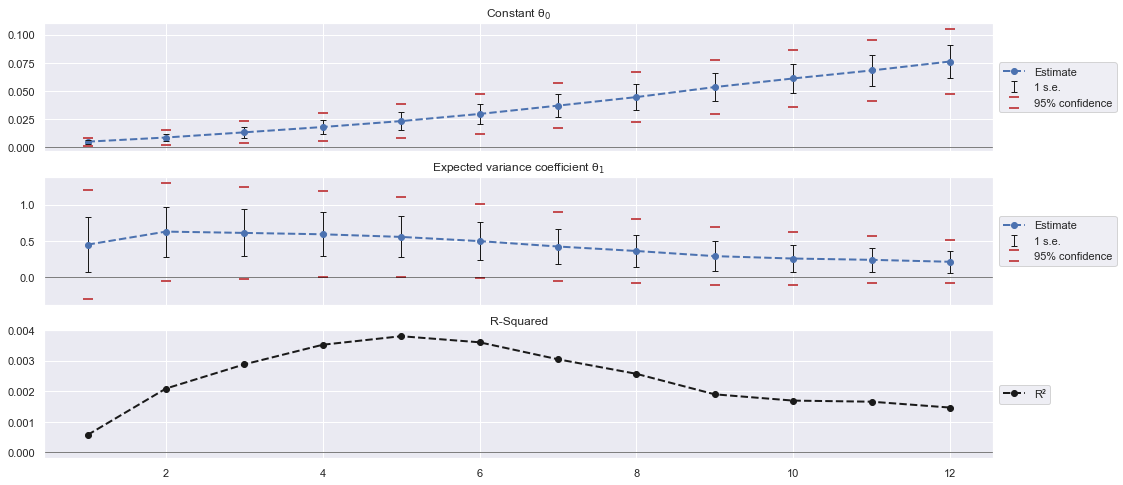

In [231]:
fig, axes = plt.subplots(3, 1, figsize=(17,8))

axes[0].plot(variance_horizon_table.T['constant','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].errorbar(range(1,13),variance_horizon_table.T['constant','coefficient estimate'],\
                 yerr=variance_horizon_table.T['constant','coefficient estimate']/variance_horizon_table.T['constant','t-statistic'],#*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='1 s.e.')
axes[0].errorbar(range(1,13),variance_horizon_table.T['constant','coefficient estimate'],\
                 yerr=variance_horizon_table.T['constant','coefficient estimate']/variance_horizon_table.T['constant','t-statistic']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_title('Constant θ$_0$')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[0].set_xticklabels([])

axes[1].plot(variance_horizon_table.T['V','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].errorbar(range(1,13),variance_horizon_table.T['V','coefficient estimate'],\
                 yerr=variance_horizon_table.T['V','coefficient estimate']/variance_horizon_table.T['V','t-statistic'],#*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='1 s.e.')
axes[1].errorbar(range(1,13),variance_horizon_table.T['V','coefficient estimate'],\
                 yerr=variance_horizon_table.T['V','coefficient estimate']/variance_horizon_table.T['V','t-statistic']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_title('Expected variance coefficient θ$_1$')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[1].set_xticklabels([])

axes[2].plot(variance_horizon_table.T['R$^2$ (model)',''], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.2)

#fig.savefig('varianceHorizonsPlot'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

In [232]:
row_labels = ['H']

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic']]), columns=range(1,13))

col = 0
for h in range(1,13):
    
    dependent = [('return',h)]
    y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)
    
    select = [(row_labels[0],h)]
    x = df_xs_reg.loc[:,select]
    
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=False, time_effects=False)
    regf = reg.fit(cov_type='kernel')
    
    reg_table.iloc[[0]+[2],col] = regf.params.values
    reg_table.iloc[[1]+[3],col] = regf.tstats.values
    #reg_table.iloc[[2]+[5],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1
    
#calc.export_df_to_latex(reg_table, 'horizonRegTable')    

entropy_horizon_table = reg_table.copy()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

In [233]:
entropy_horizon_table#.replace(np.nan,'')

1      2      3      4      5   \
constant           coefficient estimate 0.0063 0.0127 0.0186 0.0253 0.0318   
                   t-statistic          3.9624 4.0245 3.9465 4.0829 4.1347   
H                  coefficient estimate 0.0020 0.0048 0.0082 0.0097 0.0118   
                   t-statistic          0.8112 0.9907 1.1798 1.0589 1.0522   
N                                        40264  40215  40166  40117  40068   
Regression P-value                      0.0568 0.0027 0.0000 0.0000 0.0000   
R$^2$ (model)                           0.0001 0.0002 0.0004 0.0004 0.0005   

                                            6      7      8      9      10  \
constant           coefficient estimate 0.0383 0.0451 0.0523 0.0599 0.0665   
                   t-statistic          4.1779 4.2657 4.3846 4.5297 4.5886   
H                  coefficient estimate 0.0143 0.0156 0.0161 0.0160 0.0181   
                   t-statistic          1.0829 1.0473 0.9782 0.9045 0.9670   
N                                        40019  39970  39921  39872  39823   
Regression P-value                      0.0000 0.0000 0.0000 0.0000 0.0000   
R$^2$ (model)                           0.0005 0.0005 0.0005 0.0004 0.0005   

                                            11     12  
constant           coefficient estimate 0.0729 0.0799  
                   t-statistic          4.6388 4.7166  
H                  coefficient estimate 0.0204 0.0217  
                   t-statistic          1.0355 1.0499  
N                                        39774  39725  
Regression P-value                      0.0000 0.0000  
R$^2$ (model)                           0.0005 0.0005

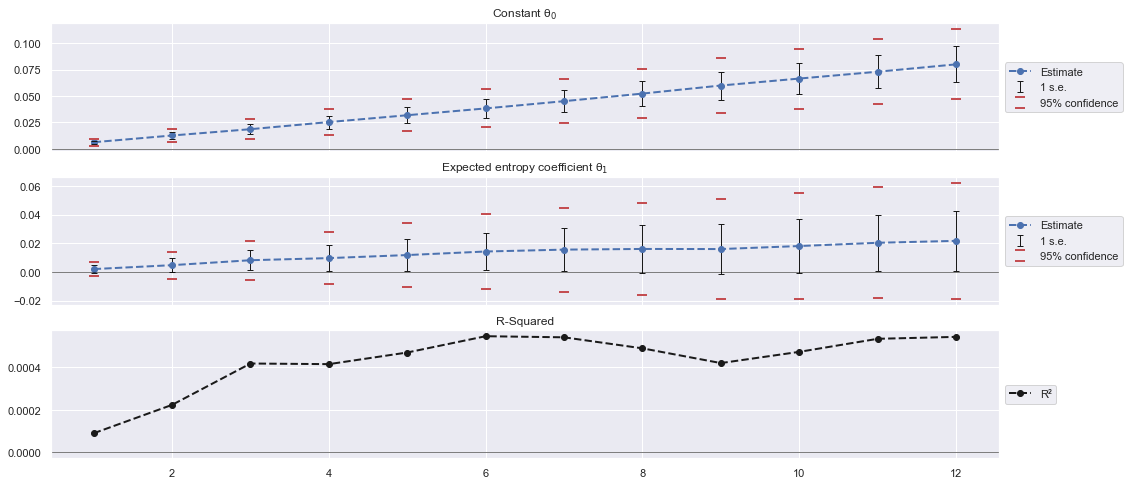

In [234]:
fig, axes = plt.subplots(3, 1, figsize=(17,8))

axes[0].plot(entropy_horizon_table.T['constant','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].errorbar(range(1,13),entropy_horizon_table.T['constant','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['constant','coefficient estimate']/entropy_horizon_table.T['constant','t-statistic'],#*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='1 s.e.')
axes[0].errorbar(range(1,13),entropy_horizon_table.T['constant','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['constant','coefficient estimate']/entropy_horizon_table.T['constant','t-statistic']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_title('Constant θ$_0$')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[0].set_xticklabels([])

axes[1].plot(entropy_horizon_table.T['H','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].errorbar(range(1,13),entropy_horizon_table.T['H','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['H','coefficient estimate']/entropy_horizon_table.T['H','t-statistic'],#*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='1 s.e.')
axes[1].errorbar(range(1,13),entropy_horizon_table.T['H','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['H','coefficient estimate']/entropy_horizon_table.T['H','t-statistic']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_title('Expected entropy coefficient θ$_1$')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[1].set_xticklabels([])

axes[2].plot(entropy_horizon_table.T['R$^2$ (model)',''], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.2)

fig.savefig('entropyHorizonsPlot'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

In [235]:
row_labels = ['H']

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic']]), columns=range(1,13))

col = 0
for h in range(1,13):
    
    dependent = [('return',h)]
    y = (1+df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h))**(1/h)-1
    
    select = [(row_labels[0],h)]
    x = df_xs_reg.loc[:,('Hss_*_KS','ss')]
    
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=False, time_effects=False)
    regf = reg.fit(cov_type='kernel')
    
    reg_table.iloc[[0]+[2],col] = regf.params.values
    reg_table.iloc[[1]+[3],col] = regf.tstats.values
    #reg_table.iloc[[2]+[5],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1
    
#calc.export_df_to_latex(reg_table, 'horizonRegTable')    

entropy_horizon_table = reg_table.copy()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

In [236]:
entropy_horizon_table#.replace(np.nan,'')

1      2      3      4      5   \
constant           coefficient estimate 0.0047 0.0032 0.0027 0.0025 0.0024   
                   t-statistic          2.1210 1.4580 1.2811 1.1950 1.1656   
H                  coefficient estimate 0.0042 0.0054 0.0057 0.0058 0.0059   
                   t-statistic          1.9180 2.5799 2.7987 2.9720 3.0796   
N                                        40264  40215  40166  40117  40068   
Regression P-value                      0.0201 0.0000 0.0000 0.0000 0.0000   
R$^2$ (model)                           0.0001 0.0004 0.0007 0.0009 0.0012   

                                            6      7      8      9      10  \
constant           coefficient estimate 0.0023 0.0023 0.0023 0.0023 0.0023   
                   t-statistic          1.1747 1.2111 1.2602 1.3263 1.3944   
H                  coefficient estimate 0.0059 0.0058 0.0057 0.0057 0.0056   
                   t-statistic          3.1762 3.2758 3.3928 3.5261 3.6617   
N                                        40019  39970  39921  39872  39823   
Regression P-value                      0.0000 0.0000 0.0000 0.0000 0.0000   
R$^2$ (model)                           0.0014 0.0016 0.0017 0.0019 0.0021   

                                            11     12  
constant           coefficient estimate 0.0023 0.0023  
                   t-statistic          1.4598 1.5361  
H                  coefficient estimate 0.0056 0.0055  
                   t-statistic          3.7692 3.8485  
N                                        39774  39725  
Regression P-value                      0.0000 0.0000  
R$^2$ (model)                           0.0023 0.0024

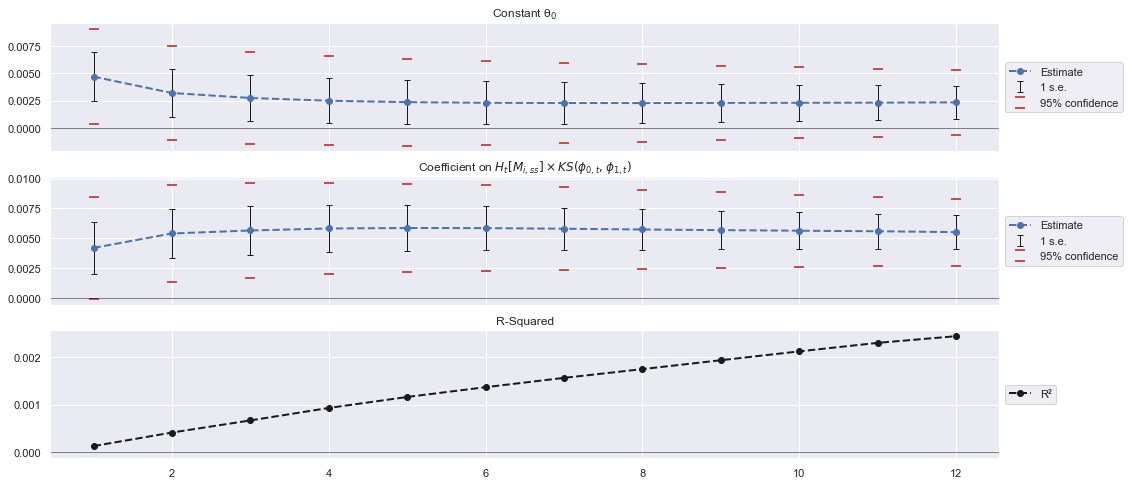

In [237]:
fig, axes = plt.subplots(3, 1, figsize=(17,8))

axes[0].plot(entropy_horizon_table.T['constant','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].errorbar(range(1,13),entropy_horizon_table.T['constant','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['constant','coefficient estimate']/entropy_horizon_table.T['constant','t-statistic'],#*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='1 s.e.')
axes[0].errorbar(range(1,13),entropy_horizon_table.T['constant','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['constant','coefficient estimate']/entropy_horizon_table.T['constant','t-statistic']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_title('Constant θ$_0$')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[0].set_xticklabels([])

axes[1].plot(entropy_horizon_table.T['H','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].errorbar(range(1,13),entropy_horizon_table.T['H','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['H','coefficient estimate']/entropy_horizon_table.T['H','t-statistic'],#*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='1 s.e.')
axes[1].errorbar(range(1,13),entropy_horizon_table.T['H','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['H','coefficient estimate']/entropy_horizon_table.T['H','t-statistic']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_title('Coefficient on $H_t[M_{i,ss}] \\times KS(\phi_{0,t},\phi_{1,t})$')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[1].set_xticklabels([])

axes[2].plot(entropy_horizon_table.T['R$^2$ (model)',''], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.2)

fig.savefig('interactHorizonsPlot'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

### Panel Regressions

In [20]:
index_dict.update({'time FE': 'time FE',
                   'industry FE': 'industry FE',
                   'R$^2$ (inclusive)': 'R$^2$ (inclusive)',
                  })

In [104]:
h = 1

dependent = [('return',h)]
independents = [[('H',h)],
                [('Hss','ss')],
                [('KS',0)],
                #[('mu_se', 0)],
                #[('sigma2_se', 0)],
                [('H_*_KS',h)],
                [('Hss_*_KS','ss')],
                #[('V',h)],
                #[('V',h),('H',h)],
                [('H',h),('V',h),('S',h),('K',h)],
                [('Hss','ss'),('V',h),('S',h),('K',h)],
                [('KS',0),('V',h),('S',h),('K',h)],
                #[('mu_se', 0),('V',h),('S',h),('K',h)],
                #[('sigma2_se', 0),('V',h),('S',h),('K',h)],
                [('H_*_KS',h),('V',h),('S',h),('K',h)],
                [('Hss_*_KS','ss'),('V',h),('S',h),('K',h)],
               ]
independents = [[('H',h)],
                [('Hss','ss')],
                [('KS',0)],
                #[('mu_se', 0)],
                #[('sigma2_se', 0)],
                [('H_*_KS',h),('H',h),('KS',0)],
                [('Hss_*_KS','ss'),('Hss','ss'),('KS',0)],
                #[('V',h)],
                #[('V',h),('H',h)],
               # [('H',h),('V',h),('S',h),('K',h)],
               # [('Hss','ss'),('V',h),('S',h),('K',h)],
               # [('KS',0),('V',h),('S',h),('K',h)],
                #[('mu_se', 0),('V',h),('S',h),('K',h)],
                #[('sigma2_se', 0),('V',h),('S',h),('K',h)],
               # [('H_*_KS',h),('V',h),('S',h),('K',h)],
               # [('Hss_*_KS','ss'),('V',h),('S',h),('K',h)],
               ]

row_labels = [str(i[0]) for i in calc.get_unique_values_from_list_of_lists(independents)]
y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic']]), columns=range(1,len(independents)*4+1))

col = 0
for select in independents:
    x = df_xs_reg.loc[:,select]
    
    for (ent,tim) in [(False,False),(True,False),(False,True),(True,True)]:
        if any([ent,tim]):
            reg = lm.PanelOLS(y.swaplevel(0,1), x.swaplevel(0,1), entity_effects=ent, time_effects=tim)
            regf = reg.fit(cov_type='kernel')
            reg_table.iloc[[row_labels.index(str(v[0]))*2+2 for v in select],col] = regf.params.values
            reg_table.iloc[[row_labels.index(str(v[0]))*2+3 for v in select],col] = regf.tstats.values
        else:
            reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=ent, time_effects=tim)
            regf = reg.fit(cov_type='kernel')
            reg_table.iloc[[0]+[row_labels.index(str(v[0]))*2+2 for v in select],col] = regf.params.values
            reg_table.iloc[[1]+[row_labels.index(str(v[0]))*2+3 for v in select],col] = regf.tstats.values
            
        #reg_table.iloc[[2]+[row_labels.index(str(v[0]))*3+5 for v in select],col] = reg.fit(cov_type='kernel').tstats.values
        reg_table.loc['time FE',col+1] = tim
        reg_table.loc['industry FE',col+1] = ent
        reg_table.loc['N',col+1] = int(regf.nobs)
        reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
        reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
        reg_table.loc['R$^2$ (inclusive)',col+1] = regf.rsquared_inclusive
    
        col += 1

reg_table.index = pd.MultiIndex.from_arrays([[index_dict.get(i) for i in list(reg_table.index.get_level_values(0))],list(reg_table.index.get_level_values(1))])        
        
calc.export_df_to_latex(reg_table, 'panelRegTable'+hmm_name)

reg_table.replace(np.nan,'')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

1   \
constant                                           coefficient estimate 0.0063   
                                                   t-statistic          3.9624   
$\mathbb{H}_t[M_{i,t+1}]$                          coefficient estimate 0.0020   
                                                   t-statistic          0.8112   
$H_t[M_{i,ss}]$                                    coefficient estimate          
                                                   t-statistic                   
$KS(\phi_{0,t},\phi_{1,t})$                        coefficient estimate          
                                                   t-statistic                   
$\mathbb{H}_t[M_{i,t+1}] \times KS(\phi_{0,t},\... coefficient estimate          
                                                   t-statistic                   
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})$   coefficient estimate          
                                                   t-statistic                   
NaN                                                                      False   
                                                                         False   
N                                                                        40264   
Regression P-value                                                      0.0568   
R$^2$ (model)                                                           0.0001   
NaN                                                                     0.0001   

                                                                            2   \
constant                                           coefficient estimate          
                                                   t-statistic                   
$\mathbb{H}_t[M_{i,t+1}]$                          coefficient estimate 0.0029   
                                                   t-statistic          0.9355   
$H_t[M_{i,ss}]$                                    coefficient estimate          
                                                   t-statistic                   
$KS(\phi_{0,t},\phi_{1,t})$                        coefficient estimate          
                                                   t-statistic                   
$\mathbb{H}_t[M_{i,t+1}] \times KS(\phi_{0,t},\... coefficient estimate          
                                                   t-statistic                   
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})$   coefficient estimate          
                                                   t-statistic                   
NaN                                                                      False   
                                                                          True   
N                                                                        40264   
Regression P-value                                                      0.0169   
R$^2$ (model)                                                           0.0001   
NaN                                                                     0.0007   

                                                                             3   \
constant                                           coefficient estimate           
                                                   t-statistic                    
$\mathbb{H}_t[M_{i,t+1}]$                          coefficient estimate -0.0009   
                                                   t-statistic          -0.8976   
$H_t[M_{i,ss}]$                                    coefficient estimate           
                                                   t-statistic                    
$KS(\phi_{0,t},\phi_{1,t})$                        coefficient estimate           
                                                   t-statistic                    
$\mathbb{H}_t[M_{i,t+1}] \times KS(\phi_{0,t},\... coefficient estimate           
                                                   t-statistic                    
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t

### Interactions

In [103]:
h = 1

dependent = [('return',h)]
independents = [[('Hss_*_KS','ss'),('Hss','ss'),('KS',0)],
                [('sq_Hss_*_KS','ss'),('Hss','ss'),('KS',0)],
                [('Hss_+_KS','ss')],
                [('rank_Hss_+_rank_KS','ss')],
                [('sq_Hss_*_KS','ss'),('Hss','ss'),('KS',0),('V',h),('S',h),('K',h)],
                [('Hss_+_KS','ss'),('V',h),('S',h),('K',h)],
               ]

row_labels = [str(i[0]) for i in calc.get_unique_values_from_list_of_lists(independents)]
y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic']]), columns=range(1,len(independents)*4+1))

col = 0
for select in independents:
    x = df_xs_reg.loc[:,select]
    
    for (ent,tim) in [(False,False),(True,False),(False,True),(True,True)]:
        if any([ent,tim]):
            reg = lm.PanelOLS(y.swaplevel(0,1), x.swaplevel(0,1), entity_effects=ent, time_effects=tim)
            regf = reg.fit(cov_type='kernel')
            reg_table.iloc[[row_labels.index(str(v[0]))*2+2 for v in select],col] = regf.params.values
            reg_table.iloc[[row_labels.index(str(v[0]))*2+3 for v in select],col] = regf.tstats.values
        else:
            reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=ent, time_effects=tim)
            regf = reg.fit(cov_type='kernel')
            reg_table.iloc[[0]+[row_labels.index(str(v[0]))*2+2 for v in select],col] = regf.params.values
            reg_table.iloc[[1]+[row_labels.index(str(v[0]))*2+3 for v in select],col] = regf.tstats.values
            
        #reg_table.iloc[[2]+[row_labels.index(str(v[0]))*3+5 for v in select],col] = reg.fit(cov_type='kernel').tstats.values
        reg_table.loc['time FE',col+1] = tim
        reg_table.loc['industry FE',col+1] = ent
        reg_table.loc['N',col+1] = int(regf.nobs)
        reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
        reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
        reg_table.loc['R$^2$ (inclusive)',col+1] = regf.rsquared_inclusive
    
        col += 1

reg_table.index = pd.MultiIndex.from_arrays([[index_dict.get(i) for i in list(reg_table.index.get_level_values(0))],list(reg_table.index.get_level_values(1))])        
        
calc.export_df_to_latex(reg_table, 'interactPanelRegTable'+hmm_name)

reg_table.replace(np.nan,'')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

1   \
constant                                           coefficient estimate -0.0016   
                                                   t-statistic          -0.2339   
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})$   coefficient estimate -0.0069   
                                                   t-statistic          -0.5562   
$H_t[M_{i,ss}]$                                    coefficient estimate  0.0078   
                                                   t-statistic           0.9230   
$KS(\phi_{0,t},\phi_{1,t})$                        coefficient estimate  0.0090   
                                                   t-statistic           0.9135   
$\sqrt{H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_... coefficient estimate           
                                                   t-statistic                    
$H_t[M_{i,ss}] + KS(\phi_{0,t},\phi_{1,t})$        coefficient estimate           
                                                   t-statistic                    
$rank(H_t[M_{i,ss}]) + rank(KS(\phi_{0,t},\phi_... coefficient estimate           
                                                   t-statistic                    
$\mathbb{V}_t[r_{i,t+1}]$                          coefficient estimate           
                                                   t-statistic                    
$\mathbb{S}_t[r_{i,t+1}]$                          coefficient estimate           
                                                   t-statistic                    
$\mathbb{K}_t[r_{i,t+1}]$                          coefficient estimate           
                                                   t-statistic                    
NaN                                                                       False   
                                                                          False   
N                                                                         40264   
Regression P-value                                                       0.0898   
R$^2$ (model)                                                            0.0002   
NaN                                                                      0.0002   

                                                                             2   \
constant                                           coefficient estimate           
                                                   t-statistic                    
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})$   coefficient estimate -0.0060   
                                                   t-statistic          -0.2704   
$H_t[M_{i,ss}]$                                    coefficient estimate  0.0188   
                                                   t-statistic           1.1977   
$KS(\phi_{0,t},\phi_{1,t})$                        coefficient estimate  0.0131   
                                                   t-statistic           0.7326   
$\sqrt{H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_... coefficient estimate           
                                                   t-statistic                    
$H_t[M_{i,ss}] + KS(\phi_{0,t},\phi_{1,t})$        coefficient estimate           
                                                   t-statistic                    
$rank(H_t[M_{i,ss}]) + rank(KS(\phi_{0,t},\phi_... coefficient estimate           
                                                   t-statistic                    
$\mathbb{V}_t[r_{i,t+1}]$                          coefficient estimate           
                                                   t-statistic                    
$\mathbb{S}_t[r_{i,t+1}]$                          coefficient estimate           
                                                   t-statistic                    
$\mathbb{K}_t[r_{i,t+1}]$                          coefficient estimate           
                                                   t-statistic                    
NaN                                                                       False   
         

### Portfolio Sorts

#### Single Sorts

In [330]:
n_portfolios = 5

In [331]:
y = df_xs_reg[('return',1)]
x1 = df_xs_reg[('Hss','ss')]
x2 = df_xs_reg[('KS',0)]
x3 = df_xs_reg[('Hss_*_KS','ss')]

In [341]:
single_sorts_table = pd.DataFrame()

for x in [x1,x2,x3]:
    # sort
    portfolio_returns, portfolio_assets, portfolio_mapping = calc.sort_portfolios(y.unstack(),x.unstack(),n_portfolios,return_assets=True)
    
    # spreading returns
    portfolio_returns['5-1'] = portfolio_returns[n_portfolios]-portfolio_returns[1]
    
    # output table
    sorted_portfolios = pd.DataFrame(index = portfolio_returns.columns)
    sorted_portfolios['mean'] = portfolio_returns.mean()
    sorted_portfolios['std'] = portfolio_returns.std()
    sorted_portfolios['T'] = portfolio_returns.count()
    sorted_portfolios['average N'] = portfolio_assets[portfolio_assets>0].mean()
    sorted_portfolios['t-stat'] = sorted_portfolios['mean']/(sorted_portfolios['std']/sorted_portfolios['T']**0.5)
    sorted_portfolios['return p.a.'] = sorted_portfolios['mean']*12
    sorted_portfolios['volatility p.a.'] = sorted_portfolios['std'] * (12**0.5)
    sorted_portfolios['SR'] = sorted_portfolios['return p.a.']/sorted_portfolios['volatility p.a.']
    sorted_portfolios.replace(np.nan,'')
    sorted_portfolios.index = pd.MultiIndex.from_product([[x.name],['low']+list(sorted_portfolios.index)[1:-2]+['high','high-low']])
    
    # combine
    single_sorts_table = single_sorts_table.append(sorted_portfolios)
    #single_sorts_table.index = single_sorts_table.index+pd.MultiIndex.from_tuples([("","")])
    single_sorts_table = single_sorts_table.append(pd.Series(name=("","")))
    
single_sorts_table = single_sorts_table.iloc[:-1]
single_sorts_table.index.set_levels(['$H_t[M_{i,ss}]$','$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})$','$KS(\phi_{0,t},\phi_{1,t})$',''],level=0,inplace=True)

single_sorts_table.replace(np.nan,'')
single_sorts_table[single_sorts_table.isna()] = ''

calc.export_df_to_latex(single_sorts_table,'singleSortsTable'+hmm_name)

single_sorts_table

mean    std  \
$H_t[M_{i,ss}]$                                  low       0.0079 0.0458   
                                                 2         0.0066 0.0500   
                                                 3         0.0074 0.0470   
                                                 4         0.0064 0.0469   
                                                 high      0.0067 0.0469   
                                                 high-low -0.0011 0.0206   
                                                                           
$KS(\phi_{0,t},\phi_{1,t})$                      low       0.0067 0.0491   
                                                 2         0.0065 0.0487   
                                                 3         0.0071 0.0457   
                                                 4         0.0076 0.0474   
                                                 high      0.0071 0.0454   
                                                 high-low  0.0003 0.0230   
                                                                           
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})$ low       0.0066 0.0483   
                                                 2         0.0071 0.0488   
                                                 3         0.0073 0.0466   
                                                 4         0.0067 0.0477   
                                                 high      0.0072 0.0444   
                                                 high-low  0.0006 0.0211   

                                                                 T average N  \
$H_t[M_{i,ss}]$                                  low      880.0000    9.4136   
                                                 2        880.0000    8.9500   
                                                 3        880.0000    9.0273   
                                                 4        880.0000    8.9500   
                                                 high     880.0000    9.4136   
                                                 high-low 880.0000             
                                                                               
$KS(\phi_{0,t},\phi_{1,t})$                      low      880.0000    9.4136   
                                                 2        880.0000    8.9500   
                                                 3        880.0000    9.0273   
                                                 4        880.0000    8.9500   
                                                 high     880.0000    9.4136   
                                                 high-low 880.0000             
                                                                               
$H_t[M_{i,ss}] \times KS(\phi_{0,t},\phi_{1,t})$ low      880.0000    9.4136   
                                                 2        880.0000    8.9500   
                                                 3        880.0000    9.0273   
                                                 4        880.0000    8.9500   
                                                 high     880.0000    9.4136   
                                                 high-low 880.0000             

                                                           t-stat return p.a.  \
$H_t[M_{i,ss}]$                                  low       5.0887      0.0943   
                                                 2         3.8866      0.0786   
                                                 3         4.6465      0.0883   
                                                 4         4.0482      0.0767   
                                                 high      4.2612      0.0809   
                                                 high-low -1.6033     -0.0134   
                                                                                
$KS(\phi_{0,t},\phi_{1,t})$                      low       4.0695      0.0808   
                                                 2    

#### Simultaneous Double Sorts

In [363]:
n_portfolios_1 = 3
n_portfolios_2 = 3

In [364]:
y = df_xs_reg[('return',1)]
x1 = df_xs_reg[('Hss','ss')]
x2 = df_xs_reg[('KS',0)]

In [367]:
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = calc.double_sort_portfolios_simultaneously(y.unstack(), x1.unstack(), x2.unstack(), n_portfolios_1 ,n_portfolios_2, return_assets=True)

#double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
#double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
#double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']
double_portfolio_returns['1,1 - 3,3'] = double_portfolio_returns['1,1']-double_portfolio_returns['3,3']
double_portfolio_returns['1,3 - 3,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['3,1']

sim_double_sorts_table = pd.DataFrame(index = double_portfolio_returns.columns)
sim_double_sorts_table['mean'] = double_portfolio_returns.mean()
sim_double_sorts_table['std'] = double_portfolio_returns.std()
sim_double_sorts_table['T'] = double_portfolio_returns.count()
sim_double_sorts_table['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
sim_double_sorts_table['t-stat'] = sim_double_sorts_table['mean']/(sim_double_sorts_table['std']/sim_double_sorts_table['T']**0.5)
sim_double_sorts_table['return p.a.'] = sim_double_sorts_table['mean']*12
sim_double_sorts_table['volatility p.a.'] = sim_double_sorts_table['std'] * (12**0.5)
sim_double_sorts_table['SR'] = sim_double_sorts_table['return p.a.']/sim_double_sorts_table['volatility p.a.']

sim_double_sorts_table.index = ['low,low']+list(sim_double_sorts_table.index)[1:-3]+['high,high','low,low-high,high','low,high-high,low']
sim_double_sorts_table = sim_double_sorts_table.rename_axis('$H_t[M_{i,ss}], KS(\phi_{0,t},\phi_{1,t})$', axis=0)

sim_double_sorts_table.replace(np.nan,'')
sim_double_sorts_table[sim_double_sorts_table.isna()] = ''

calc.export_df_to_latex(sim_double_sorts_table,'simultaneousSortsTable'+hmm_name)

sim_double_sorts_table

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
"$H_t[M_{i,ss}], KS(\phi_{0,t},\phi_{1,t})$",,,,,,,,
"low,low",0.0060,0.0503,880,4.0034,3.5565,0.0723,0.1742,0.4153
"1,2",0.0075,0.0492,880,6.1989,4.5192,0.0899,0.1704,0.5277
"1,3",0.0071,0.0486,880,4.7750,4.3400,0.0853,0.1683,0.5068
"2,1",0.0077,0.0543,868,5.0968,4.1691,0.0923,0.1882,0.4902
"2,2",0.0069,0.0457,880,4.9227,4.4801,0.0828,0.1583,0.5232
"2,3",0.0079,0.0472,880,5.8500,4.9359,0.0943,0.1637,0.5764
"3,1",0.0064,0.0503,880,5.9466,3.8029,0.0773,0.1741,0.4441
"3,2",0.0065,0.0490,880,4.6784,3.9492,0.0783,0.1698,0.4612
"high,high",0.0068,0.0474,880,4.3523,4.2446,0.0814,0.1642,0.4957


#### Sequential Double Sorts

In [369]:
n_portfolios_1 = 3
n_portfolios_2 = 3

In [370]:
y = df_xs_reg[('return',1)]
x1 = df_xs_reg[('Hss','ss')]
x2 = df_xs_reg[('KS',0)]

In [371]:
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = calc.double_sort_portfolios(y.unstack(), x1.unstack(), x2.unstack(), n_portfolios_1 ,n_portfolios_2, return_assets=True)

#double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
#double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
#double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']
double_portfolio_returns['1,1 - 3,3'] = double_portfolio_returns['1,1']-double_portfolio_returns['3,3']
double_portfolio_returns['1,3 - 3,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['3,1']

seq_double_sorts_table = pd.DataFrame(index = double_portfolio_returns.columns)
seq_double_sorts_table['mean'] = double_portfolio_returns.mean()
seq_double_sorts_table['std'] = double_portfolio_returns.std()
seq_double_sorts_table['T'] = double_portfolio_returns.count()
seq_double_sorts_table['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
seq_double_sorts_table['t-stat'] = seq_double_sorts_table['mean']/(seq_double_sorts_table['std']/seq_double_sorts_table['T']**0.5)
seq_double_sorts_table['return p.a.'] = seq_double_sorts_table['mean']*12
seq_double_sorts_table['volatility p.a.'] = seq_double_sorts_table['std'] * (12**0.5)
seq_double_sorts_table['SR'] = seq_double_sorts_table['return p.a.']/seq_double_sorts_table['volatility p.a.']

seq_double_sorts_table.index = ['low,low']+list(sim_double_sorts_table.index)[1:-3]+['high,high','low,low-high,high','low,high-high,low']
seq_double_sorts_table = seq_double_sorts_table.rename_axis('$H_t[M_{i,ss}], KS(\phi_{0,t},\phi_{1,t})$', axis=0)

seq_double_sorts_table.replace(np.nan,'')
seq_double_sorts_table[seq_double_sorts_table.isna()] = ''

calc.export_df_to_latex(seq_double_sorts_table,'sequentialSortsTable'+hmm_name)

seq_double_sorts_table

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
"$H_t[M_{i,ss}], KS(\phi_{0,t},\phi_{1,t})$",,,,,,,,
"low,low",0.0065,0.0495,880,4.9864,3.8915,0.0779,0.1714,0.4544
"1,2",0.0079,0.0502,880,5.0045,4.6763,0.0949,0.1738,0.5461
"1,3",0.0070,0.0482,880,4.9864,4.3103,0.0840,0.1668,0.5033
"2,1",0.0076,0.0520,880,5.3864,4.3347,0.0912,0.1801,0.5062
"2,2",0.0064,0.0458,880,5.0273,4.1302,0.0766,0.1588,0.4823
"2,3",0.0078,0.0468,880,5.3864,4.9437,0.0936,0.1621,0.5773
"3,1",0.0060,0.0512,880,4.9864,3.4979,0.0724,0.1772,0.4085
"3,2",0.0070,0.0502,880,5.0045,4.1348,0.0839,0.1737,0.4828
"high,high",0.0064,0.0459,880,4.9864,4.1667,0.0773,0.1589,0.4866
